<a href="https://colab.research.google.com/github/juanluisrosaramos/document_classification/blob/master/Signed_or_not_notext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#from google.colab import auth
import matplotlib.pyplot as plt
import numpy as np # linear algebra
from __future__ import print_function
import pandas as pd
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")
from sklearn import ensemble



# Descriptive analysis on the Data

Download csv and create pandas frames with Train data and Test data.

*   Train rows and columns :  (132637, 56)
*   Test rows and columns :  (10000, 55)
*   Target:  Binary with no outliers in the target distribution




In [4]:
#train_df = pd.read_csv("train.csv", sep=",")
#test_df = pd.read_csv("test.csv", sep=",")

def explore_dataset(df):
  print ('\n****** dtypes *******\n',df.dtypes) 
  print ('\n****** Floats values example *******\n',df.select_dtypes(['float64']).loc[65,:])
  print ('\n****** Integers values example *******\n',df.select_dtypes(['int64']).loc[65,:])
  print ('\n****** Object values example *******\n',df.select_dtypes(['object']).loc[5,:])
  index = df.index
  print ('\n****** Row numbers *******\n',index)
  #df.iloc[2:115, :5]
  #print ('\n****** Head *******\n',df.head())
  print ('\n****** Shape *******\n',df.shape)

data = [train_df, test_df]

for dataset in data:
  explore_dataset(dataset)



****** dtypes *******
 Unnamed: 0                                  int64
id                                          int64
Account_age_days                          float64
Country_CAT                                 int64
Currency_CAT                                int64
Day_of_the_month                            int64
Day_of_the_week                             int64
Dimensions_height                         float64
Dimensions_width                          float64
Expire_time_days                          float64
First_pending_reminders                   float64
Has_body                                    int64
Has_protection                            float64
Has_signature_position                      int64
Has_signer_name                             int64
Has_signer_phone                            int64
Has_subject                                 int64
Has_template                                int64
Has_terms_and_conditions                    int64
Highest_page              

# Let's explore the target field.
It's a binary called Target_sign with no outliers and 67% of signed documents.

1    89150
0    43487
Name: Target_sign, dtype: int64


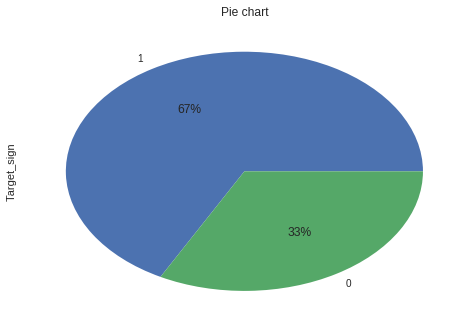

In [5]:
count_Class=pd.value_counts(train_df['Target_sign'], sort= True)
print (count_Class)
count_Class.plot(kind='pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.show()


# Missing values
Let's look for missing values in the columns the percentages against the total values of the column

In [6]:
def missing_values(df):
  #Looking for missing values 
  total = df.isnull().sum().sort_values(ascending=True)
  percent_1 = df.isnull().sum()/df.isnull().count()*100
  percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
  missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
  #Keep only when values > 0
  missing_data = missing_data[(missing_data > 0).any(axis=1)]
  return missing_data
 
for dataset in data:
  dataset = missing_values(dataset)
  print('****** Dataset missing values *********\n',dataset.head(50))
  
  
  

****** Dataset missing values *********
                                          Total      %
Dimensions_height                           15    0.0
Dimensions_width                            15    0.0
Expire_time_days                        101546   76.6
First_pending_reminders                  79071   59.6
Highest_page                             94680   71.4
In_person                                   23    0.0
Limit_quantity                          132637  100.0
Lowest_page                              94680   71.4
Num_of_signatures                        94680   71.4
Num_of_widgets                           94680   71.4
Original_sender_vs_signer_same_address    2144    1.6
Original_sender_vs_signer_same_domain     2144    1.6
Original_size                                2    0.0
Pages                                       13    0.0
Paid_per_year                           115209   86.9
Repaired                                  3817    2.9
Zipcode                                 1

# Remove columns
The similar values are founded in the Train and Test partition. Taking into account the descriptive name of the field  and the percentage of missing fields I decide to eliminate columns with a percentage of missing greater than 70%.

So, we drop those 8 columns: **Zipcode, Paid_per_year, Num_of_widgets, Num_of_signatures, Lowest_page, Limit_quantity, Highest_page, Expire_time_days**

At that point I decide to "divide and conquer" the problem and make an analysis of the raw text in other notebook to see if it's useful for the final classification. So We will also remove the column **Raw_text ** and will not use the text for this experiments.

In [7]:
#Function that return fields with % of missing 
def missing_values(df, percentage):
    columns = df.columns
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

    missing_drop = list(missing_value_df[missing_value_df.percent_missing>percentage].column_name)
    print('Columns to work with:',missing_drop)
    return missing_drop    
    
#Remove columns of both datasets
for dataset in data:
   print("Rows and columns:", dataset.shape)
   dataset.drop(['Raw_text'], axis=1, inplace=True)   
   dataset.drop(missing_values(dataset, 70), axis=1, inplace=True)
  
print("Train rows and columns after removing : ", train_df.shape)
print("Test rows and columns after removing : ", test_df.shape)

Rows and columns: (132637, 56)
Columns to work with: ['Expire_time_days', 'Highest_page', 'Limit_quantity', 'Lowest_page', 'Num_of_signatures', 'Num_of_widgets', 'Paid_per_year', 'Zipcode']
Rows and columns: (10000, 55)
Columns to work with: ['Expire_time_days', 'Highest_page', 'Limit_quantity', 'Lowest_page', 'Num_of_signatures', 'Num_of_widgets', 'Paid_per_year', 'Zipcode']
Train rows and columns after removing :  (132637, 47)
Test rows and columns after removing :  (10000, 46)


# Imputation
Let's work with missing values replacement in low percentage fields. After observing their mean and std I decide to replace them with the mean value of each column (dataset.fillna(dataset.mean())).

In [8]:
for dataset in data:   
   for field in missing_values(dataset, 2):
    print ('\n*******',field,'**********\n')
    print (dataset[field].describe())    
    #Replace values with mean
    dataset.fillna(dataset.mean(), inplace=True)

train_df.head()
#print(test_df.head())


Columns to work with: ['First_pending_reminders', 'Repaired']

******* First_pending_reminders **********

count    5.356600e+04
mean     6.077132e+05
std      8.619469e+05
min      0.000000e+00
25%      8.640000e+04
50%      6.048000e+05
75%      6.048000e+05
max      4.000000e+06
Name: First_pending_reminders, dtype: float64

******* Repaired **********

count    132637.000000
mean          0.994636
std           0.071985
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Repaired, dtype: float64
Columns to work with: ['First_pending_reminders', 'Repaired']

******* First_pending_reminders **********

count    4.075000e+03
mean     5.932275e+05
std      8.361368e+05
min      0.000000e+00
25%      8.640000e+04
50%      6.048000e+05
75%      6.048000e+05
max      4.000000e+06
Name: First_pending_reminders, dtype: float64

******* Repaired **********

count    10000.000000
mean         0.994841
std          0.070532
m

,Unnamed: 0,id,Account_age_days,Country_CAT,Currency_CAT,Day_of_the_month,Day_of_the_week,Dimensions_height,Dimensions_width,First_pending_reminders,...,Seat_admin_role,Signer_mail_domain_CAT,Signer_mail_region_CAT,Signer_mail_username_CAT,Size,Source_CAT,Time_of_the_day_seconds,Type_CAT,User_age_days,Target_sign
0,11461,11461,826.0,0,0,4,1,842.0,595.0,607713.164377,...,1,9,0,41,119111,0,45348,0,299.0,0
1,76666,76666,0.0,0,0,18,1,842.0,595.0,86400.000000,...,1,2,0,29497,41961,1,32622,0,0.0,1
2,105984,105984,847.0,0,0,25,1,842.0,595.0,607713.164377,...,1,9,0,41,119095,0,21839,0,320.0,0
3,114228,114228,848.0,0,0,26,2,842.0,595.0,607713.164377,...,1,9,0,41,118907,0,23115,0,321.0,1
4,1449,1449,824.0,0,0,2,6,842.0,595.0,607713.164377,...,1,9,0,41,1710912,0,33786,0,297.0,1


# Constant values
Let's explore constant values that are columns with the same value in each row. I decide to drop those columns.

In [9]:
def detect_uniques(df):
  unique_df = df.nunique().reset_index()
  unique_df.columns = ["col_name", "unique_count"]
  constant_df = unique_df[unique_df["unique_count"]==1]
  print(constant_df)  
  return(constant_df.col_name.tolist())


print(train_df.shape)

for dataset in data:
   print("Rows and columns:", dataset.shape)   
   dataset.drop(detect_uniques(dataset), axis=1, inplace=True)  

print(train_df.shape)

(132637, 47)
Rows and columns: (132637, 47)
                                  col_name  unique_count
21                                   Month             1
28  Original_sender_vs_signer_same_address             1
29   Original_sender_vs_signer_same_domain             1
Rows and columns: (10000, 46)
                                  col_name  unique_count
21                                   Month             1
28  Original_sender_vs_signer_same_address             1
29   Original_sender_vs_signer_same_domain             1
34                          Required_audio             1
35                      Required_photo_ids             1
(132637, 44)


I detected that in the previous step more columns where dropped in the Test partition than in the Train. Let's explore those fields

In [10]:
print(train_df['Required_audio'].describe())
print(train_df['Required_photo_ids'].describe())


count    132637.000000
mean          0.000060
std           0.007766
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Required_audio, dtype: float64
count    132637.000000
mean          0.000053
std           0.007265
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Required_photo_ids, dtype: float64


Those fields are practically always constant with a 0 value so we are going to drop them

In [11]:
train_df.drop('Required_audio', axis=1, inplace=True)
train_df.drop('Required_photo_ids', axis=1, inplace=True)
print(train_df.shape)
print(test_df.shape)


(132637, 42)
(10000, 41)


I will have a new look to the fields of the dataset and detect some fields with nearly constant values (Has_*)


In [12]:

def create_description_table(df, descriptions, round_num=2):
    df_desc = df.dtypes.to_frame(name='Data Type')
    #df_desc['Description'] = descriptions
    #df_desc['Missing Values'] = df.isnull().sum()
    df_desc['Mean'] = df.select_dtypes('number').mean().round(round_num)
    df_desc['Most Common'] = df.apply(lambda x: x.value_counts().index[0])
    df_desc['Most Common Ct'] = df.apply(lambda x: x.value_counts().iloc[0])
    df_desc['Unique Values'] = df.nunique()
    return df_desc
  
create_description_table(train_df,'Description')




,Data Type,Mean,Most Common,Most Common Ct,Unique Values
Unnamed: 0,int64,71309.99,1.662700e+04,1,132637
id,int64,71309.99,1.662700e+04,1,132637
Account_age_days,float64,637.81,8.410000e+02,4644,1255
Country_CAT,int64,0.14,0.000000e+00,115209,13
Currency_CAT,int64,0.13,0.000000e+00,115209,2
Day_of_the_month,int64,16.47,2.700000e+01,9549,28
Day_of_the_week,int64,2.11,2.000000e+00,28430,7
Dimensions_height,float64,853.12,8.420000e+02,94629,100
Dimensions_width,float64,595.06,5.950000e+02,95277,102
First_pending_reminders,float64,607713.16,6.077132e+05,79071,16


In [13]:
train_df['Has_signer_name'].describe()

count    132637.000000
mean          0.999789
std           0.014528
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Has_signer_name, dtype: float64

After analyzing those fields and taking into account the mean and standard deviation and the difference between max and min number we consider it nearly constants or bringing no value to the final result so we drop it. Index and Unnamed: 0 that has the same values as index I will also drop them

In [14]:

drop_columns = ['Has_body','Has_protection','Has_signature_position','Has_signer_name','Has_signer_phone','Unnamed: 0','id']
train_df.drop(drop_columns, axis=1, inplace=True)
test_df.drop(drop_columns, axis=1, inplace=True)
print(train_df.shape)
print(test_df.shape)





(132637, 35)
(10000, 34)


# Analytical study of the dataset
We move to study relations between features. To look of there are any linear correlations, we start applying a Spearman's rank correlation . Apparently there are no strong linear correlations. Spearman coefficients no bigger than 0,1

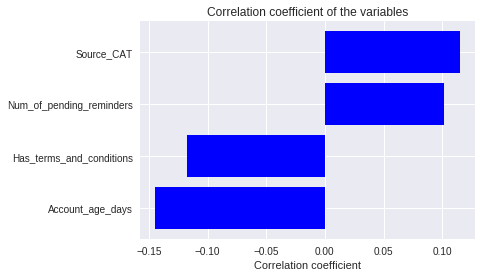

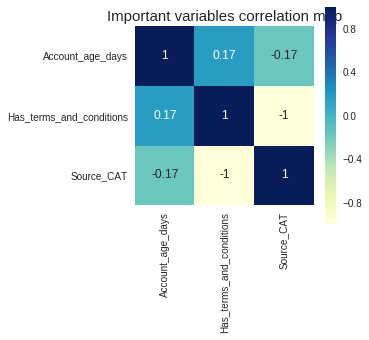

In [0]:
labels = []
values = []
for col in train_df.columns:
    if col not in ["Limit_quantity","id","Zipcode","Target_sign","Paid_per_year,Part","Raw_text"]:
        labels.append(col)
        #print (col)
        values.append(spearmanr(train_df[col].values, train_df["Target_sign"].values)[0])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)]
ind = np.arange(corr_df.shape[0])
width = 0.3
fig, ax = plt.subplots(figsize=(6,4))
#fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

import seaborn as sns

cols_to_use = corr_df[(corr_df['corr_values']>0.11) | (corr_df['corr_values']<-0.11)].col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(4, 4))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

# Feature Importance  
We will use Extra trees model
The red bars are the feature importances of the forest, along with their inter-trees variability. We clearly see fields containing time indication that has to have some relationship with the target.: Day_of_the_week, Time_of_the_day_seconds and Day_of_the_month



In [0]:
train_X = train_df.drop("Target_sign", axis=1)
train_y = np.log1p(train_df["Target_sign"].values)

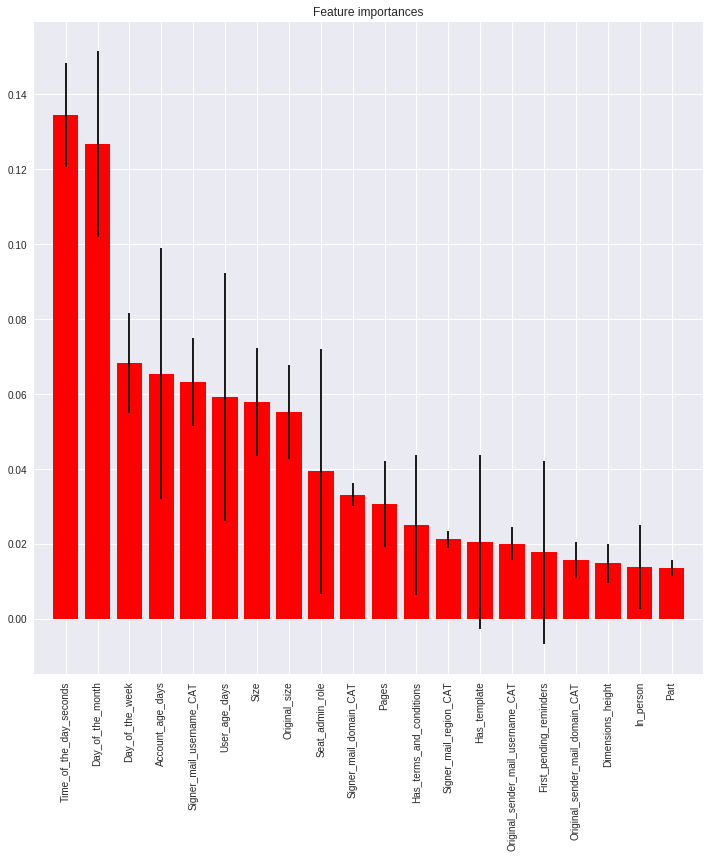

In [0]:
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

We clearly see three fields that has to have some relationship with the target.: Day_of_the_week, Time_of_the_day_seconds and Day_of_the_month let's explore those relations. First we have a look if there are no outliers


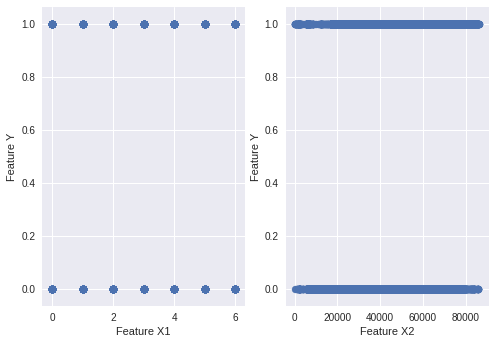

In [0]:
plt.subplot(1,2,1)
plt.scatter(train_df['Day_of_the_week'], train_df['Target_sign'])
plt.ylabel('Feature Y')
plt.xlabel('Feature X1')

plt.subplot(1,2,2)
plt.scatter(train_df['Time_of_the_day_seconds'], train_df['Target_sign'])
plt.ylabel('Feature Y')
plt.xlabel('Feature X2')

plt.show()


Let's see relationships between sign a document and time, day etc... For better human understanding we transform the time in seconds to hours. As those probably are laboral documents there exist relationships between working hours (Wednesdays at 11h) and documents signed. But this is not clearly having relation with the signed docs it's produced but the volume of docs that are happening at that times.

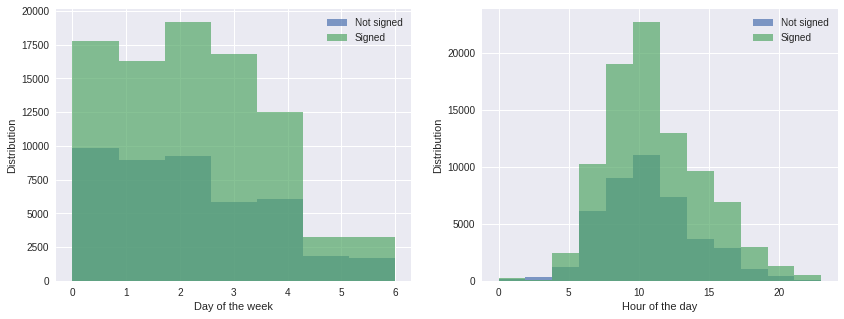

In [0]:
train_df["TimeReviewed"] = pd.to_datetime(train_df["Time_of_the_day_seconds"], unit='s').apply(lambda x: x.hour)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.hist(train_df['Day_of_the_week'][train_df['Target_sign'] == 0], bins=7, alpha = 0.7, label = 'Not signed')
plt.hist(train_df['Day_of_the_week'][train_df['Target_sign'] == 1], bins=7, alpha = 0.7, label = 'Signed')
plt.ylabel('Distribution')
plt.xlabel('Day of the week')
plt.legend()

plt.subplot(1,2,2)

plt.hist(train_df['TimeReviewed'][train_df['Target_sign'] == 0], bins=12, alpha = 0.7, label = 'Not signed')
plt.hist(train_df['TimeReviewed'][train_df['Target_sign'] == 1], bins=12, alpha = 0.7, label = 'Signed')
plt.ylabel('Distribution')
plt.xlabel('Hour of the day')
plt.legend()

plt.show()

Let's explore the day of the moth (28 days and not 30). We se that it have some direct relationship with the signed documents. Specially at the end of the month. So, from the data we can have some chance of obtaining a prediction (or classification of documents)

Number of days of the month  28


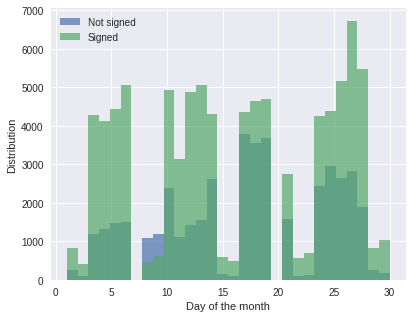

In [0]:
print('Number of days of the month ',train_df['Day_of_the_month'].nunique())
train_df["TimeReviewed"] = pd.to_datetime(train_df["Time_of_the_day_seconds"], unit='s').apply(lambda x: x.hour)
test_df["TimeReviewed"] = pd.to_datetime(test_df["Time_of_the_day_seconds"], unit='s').apply(lambda x: x.hour)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.hist(train_df['Day_of_the_month'][train_df['Target_sign'] == 0], bins=30, alpha = 0.7, label = 'Not signed')
plt.hist(train_df['Day_of_the_month'][train_df['Target_sign'] == 1], bins=30, alpha = 0.7, label = 'Signed')
plt.ylabel('Distribution')
plt.xlabel('Day of the month')
plt.legend()

plt.show()

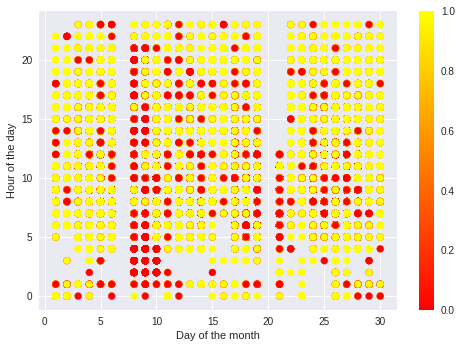

In [0]:
plt.scatter(train_df['Day_of_the_month'], train_df['TimeReviewed'], c = train_df['Target_sign'], cmap = 'autumn')
plt.ylabel('Hour of the day')
plt.xlabel('Day of the month')
plt.colorbar()
plt.show()

There are some more correlations like Account_age_days so we can try to build a model.

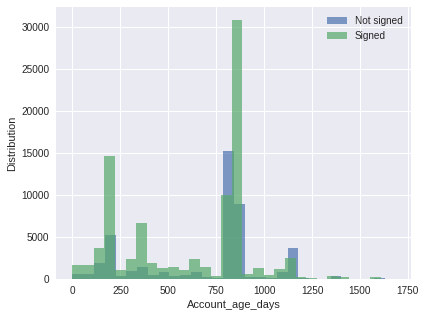

In [0]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(train_df['Account_age_days'][train_df['Target_sign'] == 0], bins=30, alpha = 0.7, label = 'Not signed')
plt.hist(train_df['Account_age_days'][train_df['Target_sign'] == 1], bins=30, alpha = 0.7, label = 'Signed')
plt.ylabel('Distribution')
plt.xlabel('Account_age_days')
plt.legend()
plt.show()

# Data modelling
Lets move to build the regression model studying different regression/classification models. We will explore the possibilities of different models using K-Fold Cross Validation and modify the hyperparameters of the model as sometimes the sklearn default parameters (specially in random forest) do not prevent overfitting and the model do not learn from the data.



In [0]:

from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.20)

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [0]:
X_train = train_df
X_train = X_train.drop("Target_sign", axis=1) 
Y_train = train_df['Target_sign']
X_test = test_df

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)



(132637, 34)
(132637,)
(10000, 34)


# Estimation of performance
We use K-folds for a first approximation (a baseline)to the results that can acchieve some very well known regressor/classification models.

In [0]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.75708685 0.75512666 0.75527744 0.75316647 0.75738842 0.75610676
 0.75972557 0.75548518 0.75277087 0.75759632]
Mean: 0.755973053772401
Standard Deviation: 0.0019886501914290963


In [0]:
decision_tree = DecisionTreeClassifier() 
scores = cross_val_score(decision_tree , X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.69202352 0.69805489 0.68636912 0.69194813 0.69632087 0.6912696
 0.69624548 0.69720274 0.69147252 0.68996456]
Mean: 0.6930871429419865
Standard Deviation: 0.003539352303741588


In [0]:
knn = KNeighborsClassifier(n_neighbors = 3) 
scores = cross_val_score(knn , X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.66917973 0.66902895 0.66842581 0.6675965  0.67068758 0.67061218
 0.67596502 0.67134133 0.67096434 0.66968258]
Mean: 0.6703484016001052
Standard Deviation: 0.002188963845232583


In [0]:
 logreg = LogisticRegression(random_state=0, solver='lbfgs',
...                          multi_class='multinomial')
scores = cross_val_score(logreg , X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.67935766 0.67935766 0.6846351  0.6799608  0.67913148 0.68222256
 0.6789807  0.68114303 0.67993667 0.68091684]
Mean: 0.6805642490691474
Standard Deviation: 0.001673658126072596


In [0]:
gaussian = GaussianNB() 
scores = cross_val_score(gaussian , X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.68124246 0.67596502 0.68063932 0.67792521 0.67890531 0.68124246
 0.67475875 0.68106763 0.67903189 0.67654377]
Mean: 0.6787321821719946
Standard Deviation: 0.0022516675311903657


In [0]:
linear_svc = LinearSVC()
scores = cross_val_score(linear_svc , X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.65606152 0.62447226 0.6713661  0.67212002 0.6619421  0.67076297
 0.3910585  0.35934555 0.6721707  0.662369  ]
Mean: 0.6041668718730749
Standard Deviation: 0.11548870623704371


In [0]:
decision_tree = DecisionTreeClassifier() 
scores = cross_val_score(decision_tree , X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.69066647 0.69986429 0.68538902 0.69074186 0.6941345  0.69209891
 0.69737636 0.69690115 0.69222649 0.69094473]
Mean: 0.6930343793153032
Standard Deviation: 0.003960697595211536


#Model exploration
We will work with the Random forest classifier to see if we can get better results (accuracy). Let's test to retrain the random Forest with the most important features (selected with a threshold of 0.009). 
Firstly we will fit a RF model with the parameters used above. The exploration of parameters that sklearn offers seems to need more computation availability has it never ends. I can provide more machines in gcloud.

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
from sklearn.model_selection import GridSearchCV, cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(X_train, Y_train)
clf.bestparams

In [0]:

random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print (acc_random_forest)

89.14


Let's retrain the RandomForest with the best features. Important Features is a function of Sklearn framework. We will use a threshold of 0.009, obtaining a 16 important features.
We retry RF model with this features.

In [0]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

#importances.head()

important_features=importances[importances.importance > 0.009]
important_features.head(35)
important_feat = important_features.index.values.tolist()
train_important_df = X_train[important_feat]
test_important_df = X_test[important_feat]

print(test_important_df.shape)
print(Y_train.shape)


random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)
random_forest.fit(train_important_df, Y_train)
Y_prediction = random_forest.predict(test_important_df)
random_forest.score(train_important_df, Y_train)
acc_random_forest = round(random_forest.score(train_important_df, Y_train) * 100, 2)
print(acc_random_forest)

(10000, 15)
(132637,)
89.7


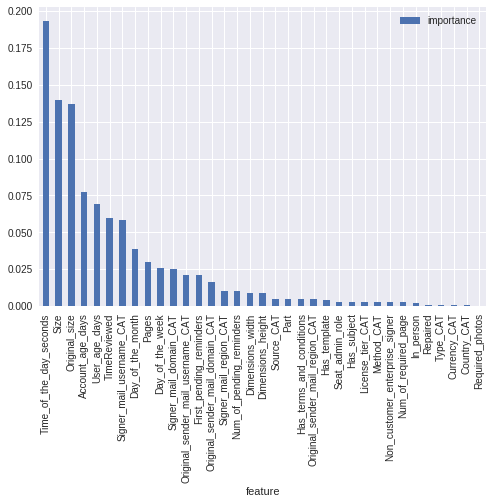

In [0]:
importances.plot.bar()

[link text](https://)The final model obtained 89.96 without the using of the text of the documents. Let's have a quick look if we are overfitting the model

In [0]:
print(acc_random_forest)
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

predictions = cross_val_predict(random_forest, train_important_df, Y_train, cv=3)
print('####### Confusion Matrix #########')
print(confusion_matrix(Y_train, predictions))
print('####### Precission / Recall #########')
print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))
print('####### F1 Score #########')
f1_score(Y_train, predictions)

89.7
####### Confusion Matrix #########
[[21049 22438]
 [10613 78537]]
####### Precission / Recall #########
Precision: 0.7777865808368408
Recall: 0.8809534492428491
####### F1 Score #########


0.8261617357001972

"predicting that a document will be signed when in reality it won’t is slightly worse than otherwise" I understand that as we want to minimize he False Positives. In this case FP is quite big 22246 where wrongly classified as Signed. I am not sure if this model can be used for prediction it depends on the trade-off that has to be considered.

79161 where correctly predicted as signed. 9989 where wrongly predicted as signed when there were not. 

How model has good abilities to predict the documents that are signed (it fits well to the trained dataset) but need to increase the precision as it is a requirement of the customer to not badly predict documents as signed.

# precision/recall tradeoff

After printing the curves I see an interesting point in stopping at threhold of 0,7 to try to imporve the precision. 

In [0]:
print(X_train.shape)
print(Y_train.shape)
y_scores = random_forest.predict_proba(train_important_df)

y_scores = y_scores[:,1]

print(y_scores)

(132637, 34)
(132637,)
[0.11347167 0.99785714 0.07760459 ... 0.75490345 0.23634797 0.12137338]


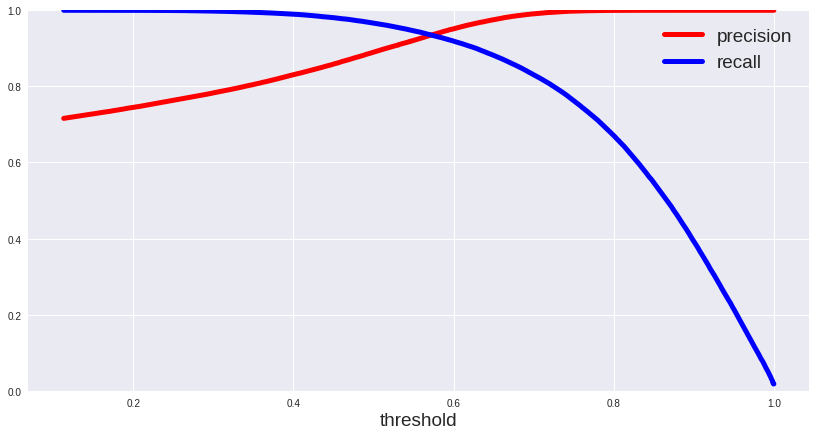

In [0]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(train_important_df)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

In [0]:
testSign = test_df
#I remove columns and just stay withthe important features
testSign = testSign[important_feat]
print(testSign.shape)

predictionsSign = random_forest.predict(testSign)


#play with the threshold to asjust the model to the tradeoff of the requirements
threshold = 0.8 # less FP
threshold = 0.5# more accuracy
threshold = 0.67# more accuracy
predicted_proba = random_forest.predict_proba(testSign)
predictionsSign = (predicted_proba [:,1] >= threshold).astype('int')

import requests

import requests
address = ''
data = f"{{\"preds\": {list(predictionsSign)}}}"
r = requests.post(address, data=data)
print(r.text)


(10000, 15)
{"TP":4776,"TN":2264,"FP":1036,"FN":1924,"precision":0.8217481073640743,"recall":0.7128358208955224,"f1_score":0.7634271099744245,"accuracy":0.704}
